# Models for Larger Dataset

In [1]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Dense, Activation, Dropout, Lambda
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.applications.inception_v3 import InceptionV3

In [3]:
import os, sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [28]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from keras_addon import ImageFrameGenerator

from DL_utils import plot_roc

In [4]:
path  =  "/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/colonoscopy2/"
model_path = path + 'models/'
if not os.path.exists(model_path): 
    os.mkdir(model_path)
data_path = path+'subset/'

In [5]:
batch_size = 32

## Preparation
Check up the labels and image files. Split into training and validation sets. 

In [6]:
filenames = os.listdir(data_path)

In [11]:
labels = pd.read_excel(path+'colonoscopy_mayo_labeled_07May.xlsx')

In [7]:
labels.columns

Index(['basefile', 'pathname', 'SourceReportName', 'Inflamm_Mayo_0',
       'Inflamm_Mayo_1', 'Inflamm_Mayo_2', 'Inflamm_Mayo_3', 'Poor_GRAPHIC',
       'Poor_Image_UNCLASSIFIED'],
      dtype='object')

In [13]:
double_labeled = labels[['Inflamm_Mayo_0', 'Inflamm_Mayo_1', 'Inflamm_Mayo_2', 'Inflamm_Mayo_3']].apply(sum, axis=1)>1

In [14]:
double_labeled.value_counts()

False    12778
True        38
dtype: int64

In [15]:
labels['Poor_Image_UNCLASSIFIED'].value_counts()

False    12816
Name: Poor_Image_UNCLASSIFIED, dtype: int64

In [16]:
labels['Poor_GRAPHIC'].value_counts()

False    12816
Name: Poor_GRAPHIC, dtype: int64

In [17]:
errors = ['BM_col_2608-2.jpg', 'FS_273.jpg', 'FS_405.jpg', 'FS_1434.jpg', 'FS_2259.jpg', 'FS_2916.jpg']

In [20]:
labels = labels.loc[~labels['basefile'].isin(errors)]

In [18]:
labels = labels.loc[~double_labeled]

In [22]:
labels.shape

(12772, 9)

Make a subset copy of the images, so the generator can run faster. 

In [34]:
labeled = set(labels.basefile)

from shutil import copyfile

for f in filenames:
    if f in labeled:
        copyfile(data_path+f, path+'subset/'+f)

In [62]:
labels.Inflamm_Mayo_3.value_counts()

False    11666
True      1150
Name: Inflamm_Mayo_3, dtype: int64

Create labels for multi-binary classification:

In [23]:
labels['split0_123'] = (~labels.Inflamm_Mayo_0).astype(int)
labels['split01_23'] = (labels.Inflamm_Mayo_2 | labels.Inflamm_Mayo_3).astype(int)
labels['split012_3'] = labels.Inflamm_Mayo_3.astype(int)

In [33]:
labels.split0_123.value_counts()

0    7181
1    5591
Name: split0_123, dtype: int64

In [34]:
labels.split01_23.value_counts()

0    9936
1    2836
Name: split01_23, dtype: int64

In [35]:
labels.split012_3.value_counts()

0    11633
1     1139
Name: split012_3, dtype: int64

In [24]:
labels['Mayo_score'] = 0
labels.loc[labels.Inflamm_Mayo_1, 'Mayo_score'] = 1
labels.loc[labels.Inflamm_Mayo_2, 'Mayo_score'] = 2
labels.loc[labels.Inflamm_Mayo_3, 'Mayo_score'] = 3

In [25]:
labels.Mayo_score.value_counts()

0    7181
1    2755
2    1697
3    1139
Name: Mayo_score, dtype: int64

In [6]:
labels = pd.read_csv(path+'train_labels.csv')

In [45]:
labels = labels.reset_index(drop=True)

In [7]:
split = GroupShuffleSplit(n_splits=1, test_size=0.11, random_state=24)

In [8]:
ind = split.split(labels, groups=labels['SourceReportName'])

In [9]:
trn_ind, val_ind = next(ind)

In [10]:
trn_patients = set(labels.loc[trn_ind, 'SourceReportName'])
val_patients = set(labels.loc[val_ind, 'SourceReportName'])

In [11]:
trn_df = labels.loc[trn_ind]
val_df = labels.loc[val_ind]

In [12]:
trn_ind.shape, val_ind.shape

((10198,), (1274,))

In [13]:
len(trn_patients), len(val_patients)

(1848, 229)

In [41]:
val_df.split012_3.value_counts()

0.0    1188
1.0     107
Name: split012_3, dtype: int64

In [42]:
val_df.Mayo_score.value_counts()

0.0    713
1.0    309
2.0    166
3.0    107
Name: Mayo_score, dtype: int64

In [54]:
tst_df.to_csv(path+'test_labels.csv', index=False)

In [55]:
trn_df.to_csv(path+'train_labels.csv', index=False)

In [14]:
tst_df = pd.read_csv(path+'test_labels.csv')

In [18]:
tst_df.columns

Index(['basefile', 'pathname', 'SourceReportName', 'Inflamm_Mayo_0',
       'Inflamm_Mayo_1', 'Inflamm_Mayo_2', 'Inflamm_Mayo_3', 'Poor_GRAPHIC',
       'Poor_Image_UNCLASSIFIED', 'Mayo_score', 'split0_123', 'split01_23',
       'split012_3'],
      dtype='object')

In [16]:
len(tst_df), len(tst_df.SourceReportName.unique())

(1300, 231)

In [59]:
freq[0]

6440

## Data Generator

In [18]:
from keras_addon import ImageFrameGenerator

In [56]:
import keras_addon
from importlib import reload
reload(keras_addon)

<module 'keras_addon' from '/home/wsliu/Codes/DLproj/keras_addon.py'>

In [58]:
train_gen = ImageFrameGenerator( 
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

In [19]:
validation_gen = ImageFrameGenerator()

In [52]:
train_itr = train_gen.flow_from_frame(data_path, trn_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), batch_size=batch_size)

Found 12816 images in the directory.
Using split0_123 as continuous label. 
Using split01_23 as continuous label. 
Using split012_3 as continuous label. 
Using 11433 images to generate mini-batches.


In [16]:
val_itr = validation_gen.flow_from_frame(data_path, val_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), batch_size=batch_size, shuffle=False)

Found 12816 images in the directory.
Using 1170 images to generate mini-batches.


In [10]:
tst_itr = validation_gen.flow_from_frame(data_path, tst_df, 'basefile', ['split0_123', 'split01_23', 'split012_3'], 
                                     target_size=(256, 320), batch_size=batch_size, shuffle=False)

Found 12816 images in the directory.
Using 1304 images to generate mini-batches.


In [60]:
tst_iter = validation_gen.flow_from_frame(data_path, tst_df, 'basefile', ['Mayo_score', 'Poor_GRAPHIC'], 
                                          label_types=['categorical', 'binary'],
                                     target_size=(256, 320), batch_size=8, shuffle=False)

Found 12816 images in the directory.
Using Mayo_score as categorical label, with levels: {0: 0.0, 1: 1.0, 2: 2.0, 3: 3.0}
Using Poor_GRAPHIC as binary label. 
Using 1295 images to generate mini-batches.


## Model with 3 binary output

In [12]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)

output1 = Dense(1, activation='sigmoid', name='split0_123')(x)
output2 = Dense(1, activation='sigmoid', name='split01_23')(x)
output3 = Dense(1, activation='sigmoid', name='split012_3')(x)

model = Model(inputs=base_model.input, outputs=[output1, output2, output3])

In [64]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [65]:
checkpointer = ModelCheckpoint(filepath=model_path+'phase2_0511.h5', verbose=0, save_best_only=True, 
                               save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=30)

In [ ]:
history = model.fit_generator(train_itr, steps_per_epoch=train_itr.n // batch_size, epochs=200, 
                              validation_data=val_itr, validation_steps=val_itr.n // batch_size, 
                              callbacks=[checkpointer, reduce_lr, earlystop], 
                                verbose=1)

Epoch 1/200
286/286 [==============================] - 457s 2s/step - loss: 1.0631 - split0_123_loss: 0.5156 - split01_23_loss: 0.3514 - split012_3_loss: 0.1961 - split0_123_acc: 0.7462 - split01_23_acc: 0.8523 - split012_3_acc: 0.9227 - val_loss: 1.3938 - val_split0_123_loss: 0.6226 - val_split01_23_loss: 0.4715 - val_split012_3_loss: 0.2997 - val_split0_123_acc: 0.7384 - val_split01_23_acc: 0.8094 - val_split012_3_acc: 0.8839
Epoch 2/200
286/286 [==============================] - 444s 2s/step - loss: 0.9114 - split0_123_loss: 0.4434 - split01_23_loss: 0.2974 - split012_3_loss: 0.1706 - split0_123_acc: 0.7975 - split01_23_acc: 0.8738 - split012_3_acc: 0.9332 - val_loss: 1.8149 - val_split0_123_loss: 0.9771 - val_split01_23_loss: 0.6006 - val_split012_3_loss: 0.2373 - val_split0_123_acc: 0.6710 - val_split01_23_acc: 0.8496 - val_split012_3_acc: 0.9411
Epoch 3/200
286/286 [==============================] - 439s 2s/step - loss: 0.8662 - split0_123_loss: 0.4284 - split01_23_loss: 0.2751 -

### Result Evaluation

In [79]:
model.load_weights(model_path+'phase2_0511_2.h5')

In [80]:
y = model.predict_generator(tst_itr, verbose=1)

44/44 [==============================] - 20s 451ms/step


In [81]:
y_pred = np.concatenate(y, axis=1)

In [63]:
y_true = tst_df[['split0_123', 'split01_23', 'split012_3']].values

In [64]:
y_pred.shape, y_true.shape

((1378, 3), (1378, 3))

{0: 0.9108663344697963, 1: 0.9609973839110529, 2: 0.9733952183688666}

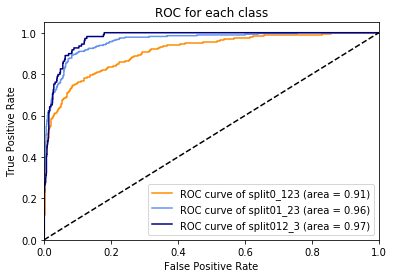

In [82]:
plot_roc(y_pred, y_true, classes=['split0_123', 'split01_23', 'split012_3'])

## Model with 4 binary output

In [20]:
tst_gen = ImageFrameGenerator()
tst_itr = tst_gen.flow_from_frame(data_path, tst_df, 'basefile', 
                                   ['Inflamm_Mayo_0', 'Inflamm_Mayo_1', 'Inflamm_Mayo_2', 'Inflamm_Mayo_3'], 
                                     target_size=(256, 320), batch_size=batch_size, shuffle=False)

Found 12816 images in the directory.
Using Inflamm_Mayo_0 as continuous label. 
Using Inflamm_Mayo_1 as continuous label. 
Using Inflamm_Mayo_2 as continuous label. 
Using Inflamm_Mayo_3 as continuous label. 
Using 1300 images to generate mini-batches.


In [67]:
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)

output0 = Dense(1, activation='sigmoid', name='Inflamm_Mayo_0')(x)
output1 = Dense(1, activation='sigmoid', name='Inflamm_Mayo_1')(x)
output2 = Dense(1, activation='sigmoid', name='Inflamm_Mayo_2')(x)
output3 = Dense(1, activation='sigmoid', name='Inflamm_Mayo_3')(x)

model = Model(inputs=base_model.input, outputs=[output0, output1, output2, output3])

In [68]:
model.load_weights(model_path+'phase2_4binary0515.h5')

In [23]:
y = model.predict_generator(tst_itr, verbose=1)

41/41 [==============================] - 43s 1s/step


In [26]:
y_pred = np.concatenate(y, axis=1)

In [24]:
y_true = tst_df[['Inflamm_Mayo_0', 'Inflamm_Mayo_1', 'Inflamm_Mayo_2', 'Inflamm_Mayo_3']].values

{0: 0.9357103368025127,
 1: 0.8619281596452328,
 2: 0.9152698373364958,
 3: 0.971330124081315}

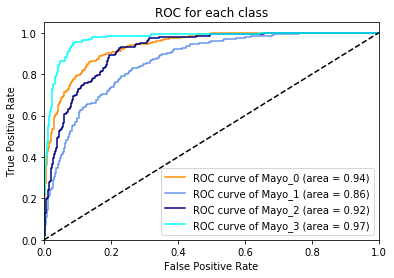

In [30]:
plot_roc(y_pred, y_true, classes=['Mayo_0', 'Mayo_1', 'Mayo_2', 'Mayo_3'])

## Multi-Class Classification

In [32]:
tst_gen = ImageFrameGenerator()
tst_itr = tst_gen.flow_from_frame(data_path, tst_df, 'basefile', 
                                   ['Mayo_score'], label_types=['categorical'],
                                     target_size=(256, 320), batch_size=batch_size, shuffle=False)

Found 12816 images in the directory.
Using Mayo_score as categorical label, with levels: {0: 0, 1: 1, 2: 2, 3: 3}
Using 1300 images to generate mini-batches.


In [33]:
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)

output = Dense(4, activation='softmax', name='Mayo_score')(x)

model = Model(inputs=base_model.input, outputs=output)

In [34]:
model.load_weights(model_path+'phase2_multiclass0515.h5')

In [35]:
y = model.predict_generator(tst_itr, verbose=1)

41/41 [==============================] - 21s 500ms/step


In [44]:
y_pred = pd.Series(y.argmax(axis=1), dtype=int, name='Mayo_predicted')

In [46]:
y_true = tst_df['Mayo_score']
y_true.name = 'Mayo_true'
y_true = y_true.astype(int)

In [48]:
pd.crosstab(index=y_true, columns=y_pred, margins=True)

Mayo_predicted,0,1,2,3,All
Mayo_true,,,,,
0,706,15,16,4,741
1,147,79,47,2,275
2,17,16,88,26,147
3,10,3,41,83,137
All,880,113,192,115,1300


In [50]:
pd.crosstab(index=y_true, columns=y_pred, normalize='index')

Mayo_predicted,0,1,2,3
Mayo_true,,,,
0,0.952767,0.020243,0.021592,0.005398
1,0.534545,0.287273,0.170909,0.007273
2,0.115646,0.108844,0.598639,0.176871
3,0.072993,0.021898,0.299270,0.605839


## Test on Video data

In [51]:
video_path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/UC_colonoscopy/'

In [52]:
video_labels = pd.read_excel(video_path+'UC_Images_Labels/UC_deeplearning_imageLabels.xlsx')

In [58]:
video_labels.columns

Index(['ID', 'basefile', 'pathname', 'file_seq', 'SubjectID', 'Time_sec',
       'Video_time', 'Mayo_0', 'Mayo_1', 'Mayo_2', 'Mayo_3',
       'Poor_Image_underwater', 'Poor_Image_focus', 'Poor_Image_Stool',
       'Poor_Image_Bubbles', 'Post_Biopsy_Bleeding', 'Findings_BiopsyForceps',
       'Findings_Snare', 'Finding_Polyps', 'Finding_Pseudopolyps',
       'Findings_Waterjet', 'Findings_Diverticula', 'Location_Ileum',
       'Location_Cecum', 'Location_Retroflexion', 'Comments',
       'Poor_Image_UNCLASSIFIED', 'Quality_Good', 'Findings_Pills_retained',
       'Location_appendicealOriface', 'filename'],
      dtype='object')

In [59]:
video_labels = video_labels.loc[video_labels.Quality_Good==1]

In [61]:
video_labels = video_labels.loc[video_labels[['Mayo_0', 'Mayo_1', 'Mayo_2', 'Mayo_3']].apply(sum, axis=1)==1]

In [54]:
video_labels['filename'] = [str(s)+str(b) for s, b in zip(video_labels.SubjectID, video_labels.basefile)]

In [63]:
video_labels = video_labels.dropna(subset=['filename', 'Mayo_0', 'Mayo_1', 'Mayo_2', 'Mayo_3'])

In [74]:
video_labels['Mayo_score'] = 0
video_labels.loc[video_labels.Mayo_1, 'Mayo_score'] = 1
video_labels.loc[video_labels.Mayo_2, 'Mayo_score'] = 2
video_labels.loc[video_labels.Mayo_3, 'Mayo_score'] = 3

In [82]:
video_labels.Mayo_score.value_counts()

0    5475
1    1081
2     583
3     281
Name: Mayo_true, dtype: int64

In [64]:
video_labels.shape

(7420, 31)

### Prediction by 4 binary model

In [65]:
tst_gen = ImageFrameGenerator()
tst_itr = tst_gen.flow_from_frame(video_path+'all/', video_labels, 'filename', 
                                   ['Mayo_0', 'Mayo_1', 'Mayo_2', 'Mayo_3'], label_types=['binary']*4, 
                                     target_size=(256, 320), batch_size=batch_size, shuffle=False)

Found 7433 images in the directory.
Using Mayo_0 as binary label. 
Using Mayo_1 as binary label. 
Using Mayo_2 as binary label. 
Using Mayo_3 as binary label. 
Using 7420 images to generate mini-batches.


In [67]:
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)

output0 = Dense(1, activation='sigmoid', name='Inflamm_Mayo_0')(x)
output1 = Dense(1, activation='sigmoid', name='Inflamm_Mayo_1')(x)
output2 = Dense(1, activation='sigmoid', name='Inflamm_Mayo_2')(x)
output3 = Dense(1, activation='sigmoid', name='Inflamm_Mayo_3')(x)

model = Model(inputs=base_model.input, outputs=[output0, output1, output2, output3])

In [68]:
model.load_weights(model_path+'phase2_4binary0515.h5')

In [69]:
y = model.predict_generator(tst_itr, verbose=1)

232/232 [==============================] - 211s 911ms/step


In [70]:
y_pred = np.concatenate(y, axis=1)

In [71]:
y_true = video_labels[['Mayo_0', 'Mayo_1', 'Mayo_2', 'Mayo_3']].values

{0: 0.9352069584815298,
 1: 0.883489415989209,
 2: 0.9197086481562459,
 3: 0.9557600250042497}

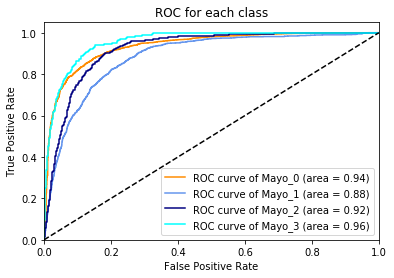

In [72]:
plot_roc(y_pred, y_true, classes=['Mayo_0', 'Mayo_1', 'Mayo_2', 'Mayo_3'])

### Prediction by multiclass model

In [75]:
tst_gen = ImageFrameGenerator()
tst_itr = tst_gen.flow_from_frame(video_path+'all/', video_labels, 'filename', 
                                   ['Mayo_score'], label_types=['categorical'], 
                                     target_size=(256, 320), batch_size=batch_size, shuffle=False)

Found 7433 images in the directory.
Using Mayo_score as categorical label, with levels: {0: 0, 1: 1, 2: 2, 3: 3}
Using 7420 images to generate mini-batches.


In [76]:
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)

output = Dense(4, activation='softmax', name='Mayo_score')(x)

model = Model(inputs=base_model.input, outputs=output)

In [77]:
model.load_weights(model_path+'phase2_multiclass0515.h5')

In [78]:
y = model.predict_generator(tst_itr, verbose=1)

232/232 [==============================] - 199s 858ms/step


In [79]:
y_pred = pd.Series(y.argmax(axis=1), dtype=int, name='Mayo_predicted')

In [80]:
y_true = video_labels['Mayo_score']
y_true.name = 'Mayo_true'
y_true = y_true.astype(int)

In [84]:
pd.crosstab(index=y_true, columns=y_pred, margins=True)

Mayo_predicted,0,1,2,3,All
Mayo_true,,,,,
0,1353,99,146,31,1629
1,177,6,29,8,220
2,68,6,19,0,93
All,1598,111,194,39,1942


In [87]:
pd.crosstab(index=y_true, columns=y_pred, normalize='index')

Mayo_predicted,0,1,2,3
Mayo_true,,,,
0,0.830571,0.060773,0.089626,0.019030
1,0.804545,0.027273,0.131818,0.036364
2,0.731183,0.064516,0.204301,0.000000


In [91]:
pd.crosstab(pd.Series(y_true.values, name='Mayo_true'), pd.Series(y_pred.values, name='Mayo_predicted'), margins=True)

Mayo_predicted,0,1,2,3,All
Mayo_true,,,,,
0,5086,180,169,40,5475
1,389,483,197,12,1081
2,63,116,390,14,583
3,18,8,165,90,281
All,5556,787,921,156,7420


In [92]:
pd.crosstab(pd.Series(y_true.values, name='Mayo_true'), pd.Series(y_pred.values, name='Mayo_predicted'), normalize='index')

Mayo_predicted,0,1,2,3
Mayo_true,,,,
0,0.928950,0.032877,0.030868,0.007306
1,0.359852,0.446809,0.182239,0.011101
2,0.108062,0.198971,0.668954,0.024014
3,0.064057,0.028470,0.587189,0.320285


## Model with Continuous Output

In [11]:
from keras.applications.inception_v3 import InceptionV3

In [33]:
from ggplot import *

In [12]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

output1 = Dense(1, activation='linear', name='Mayo_score')(x)

model = Model(inputs=base_model.input, outputs=output1)

In [60]:
model.load_weights(model_path+'phase2_0512_cont_f.h5')

In [61]:
y = model.predict_generator(tst_itr, verbose=1)

41/41 [==============================] - 19s 460ms/step


In [62]:
y_pred = y.reshape((y.shape[0],))

In [17]:
y_true = tst_df.Mayo_score.values

In [20]:
y_pred.shape, y_true.shape

((1304,), (1304,))

In [64]:
out_df = pd.DataFrame(dict(y_pred=y_pred, y_true=y_true))

In [66]:
out_df.y_true = out_df.y_true.astype('str')

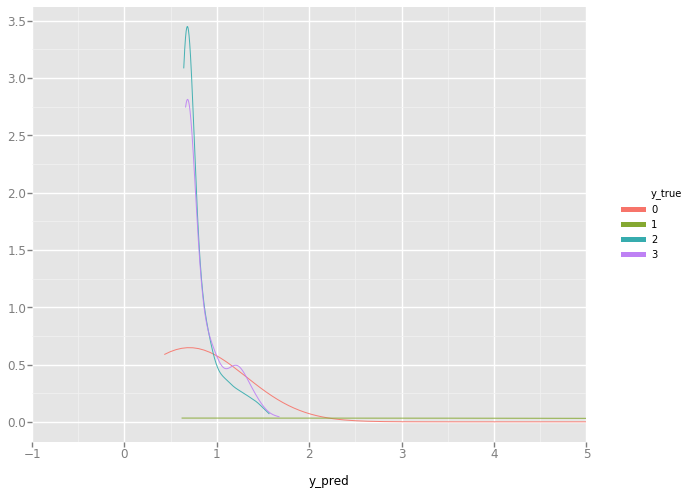

<ggplot: (-9223369082710965269)>

In [54]:
ggplot(out_df, aes(x='y_pred', colour='y_true')) + geom_density(alpha=0.9) + xlim(low=-1, high=5)

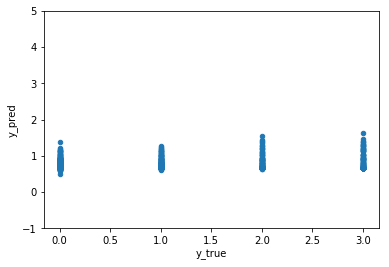

In [65]:
out_df.plot.scatter(x='y_true', y='y_pred', ylim=(-1, 5))

In [67]:
out_df.groupby('y_true').describe()

y_pred                                                               \
        count      mean        std       min       25%       50%       75%   
y_true                                                                       
0       741.0  0.791134   1.953692  0.498022  0.660901  0.662145  0.685567   
1       277.0  3.531302  35.020256  0.622300  0.660998  0.665059  0.787127   
2       147.0  0.788031   0.200312  0.639661  0.661511  0.675686  0.855202   
3       139.0  0.823122   0.230037  0.657027  0.662225  0.683953  0.923668   

                    
               max  
y_true              
0        51.665691  
1       546.386963  
2         1.540114  
3         1.625863